In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

inputs_path = os.path.join(os.getcwd(), 'data', 'inputs')
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

In [2]:
instruments = [

    'SPY', 'IWM', 'EEM', 'TLT', 'USO', 'GLD', 
    'XLF', 'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY',
    'XLP', 'XLE', 'AGG', 'DBC', 'HYG', 'LQD','UUP'

]

data = pd.read_csv(os.path.join(inputs_path, 'sample', 'etfs.csv'), sep = ';')
data['date'] = pd.to_datetime(data['date'])

# set date as index
data.set_index('date', inplace=True)

# select instruments
data = data[instruments]

# resample prices to business days
data = data.resample('B').ffill()

# dropna
data = data.dropna()

# compute returns
returns = data.pct_change().dropna()

# define train and test periods
train_returns, test_returns = train_test_split(returns, test_size=0.2, shuffle=False)

import random
import math
import torch
from tqdm import tqdm

def create_circular_blocks(time_series, Bsize) -> list:
    """
    Method to create the circular block sets.

    Returns:
        Block_sets (list): list of blocks
    """

    N = time_series.shape[0]
    dtime_series = torch.vstack([time_series.clone().detach(), time_series[:Bsize,:].clone().detach()])

    Block_sets = list()
    for i in range(N):
        j = i + Bsize
        Block = dtime_series[i:j,:]
        Block_sets.append(Block)
    
    return Block_sets

def sample(time_series, Bsize, Blocks):
    N = time_series.shape[0]
    b = int(math.ceil(N / Bsize))

    selected_blocks = random.choices(Blocks, k = b)

    sampled_data = torch.vstack(selected_blocks)
    return sampled_data[:N, :]

def sample_many_paths(time_series, Bsize, Blocks, k: int, use_seed=True) -> torch.Tensor:
    """
    Apply the sample function k times.

    
    Args:
        k (int): number of samples to generate.

    Returns:
        all_samples (torch.Tensor): all sampled data
    """
    
    seeds1 = []
    all_samples = []
    for i in tqdm(range(k)):

        if use_seed:
            random.seed(i * 5)
            seeds1.append(i * 5)

        sampled_data = sample(time_series, Bsize, Blocks)
        all_samples.append(sampled_data)
    
    # self.seeds['seeds1'] = seeds1
    
    return torch.stack(all_samples)

time_series = torch.tensor(train_returns.values, dtype=torch.float32)
Bsize = 10
k = 100

# divide time series into time_series.shape[0] circular blocks
Blocks = create_circular_blocks(time_series, Bsize)

# sample k paths of size time_series.shape[0] from the blocks
sampled_paths = sample_many_paths(time_series, Bsize, Blocks, k)

from tqdm import tqdm

# define macd parameters
parameters_list = [
    [4, 8], [4, 12], [4, 24], [4, 48], [4, 96], [4, 192], [4, 384],
    [8, 12], [8, 24], [8, 48], [8, 96], [8, 192], [8, 384],
    [16, 24], [16, 48], [16, 96], [16, 192], [16, 384],
    [32, 48], [32, 96], [32, 192], [16, 384]
]

# loop through the available parameters
train_metrics = []
for window in tqdm(parameters_list):

    # loop through k sample paths
    for i in range(k):

        # select the i-th sampled path
        boot_returns = pd.DataFrame(sampled_paths[i, :, :])

        # compute signal
        short_window, long_window = window
        ## compute the MACD signal
        signal = boot_returns.ewm(span=short_window).mean() - boot_returns.ewm(span=long_window).mean()

        # compute positions
        positions = signal.map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

        # portfolio returns
        portfolio_returns = boot_returns.shift(-1) * positions

        # aggregate returns
        portfolio_returns['portfolio'] = portfolio_returns.mean(axis=1)

        # vol scale portfolio returns
        rolling_portfolio_vol = (portfolio_returns['portfolio'].ewm(span=90, min_periods=90).std() * np.sqrt(252)).shift(+1) + 1e-5
        portfolio_returns['portfolio_scaled'] = portfolio_returns['portfolio'] * (0.10 / rolling_portfolio_vol)

        # compute maxdd
        cumulative_returns = (1 + portfolio_returns['portfolio_scaled']).cumprod()
        running_maximum = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_maximum) / running_maximum
        max_drawdown = drawdown.min()

        # compute relevant metrics
        metrics = {
            'param': str(window),
            'boot_sample': i,
            'sharpe': portfolio_returns['portfolio'].mean() / portfolio_returns['portfolio'].std() * np.sqrt(252),
            'maxDD': max_drawdown,
        }

        # append results
        train_metrics.append(metrics)
train_metrics_df = pd.DataFrame(train_metrics)

# compute average Sharpe ratio for each parameter across all bootstrapped samples
param_boot_sharpe_df = train_metrics_df[['param', 'sharpe', 'maxDD']].groupby('param').mean().sort_values(by='sharpe', ascending=False)

# compute average Sharpe ratio for each parameter across all bootstrapped samples
param_boot_sharpe_df = train_metrics_df[['param', 'sharpe', 'maxDD']].groupby('param').mean().sort_values(by='sharpe', ascending=False)

# maximum
train_max_param = str(param_boot_sharpe_df.index[0])
train_max_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False)['maxDD'].index[0])

# 90th percentile
train_90_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.9))])
train_90_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.9))].name)

# 80th percentile
train_80_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.8))])
train_80_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.8))].name)

# 70th percentile
train_70_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.7))])
train_70_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.7))].name)

# 60th percentile
train_60_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.6))])
train_60_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.6))].name)

# 50th percentile
train_50_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.5))])
train_50_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.5))].name)

# 40th percentile
train_40_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.4))])
train_40_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.4))].name)

# 30th percentile
train_30_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.3))])
train_30_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.3))].name)

# 20th percentile
train_20_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.2))])
train_20_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.2))].name)

# 10th percentile
train_10_param = str(param_boot_sharpe_df.index[int(len(param_boot_sharpe_df) * (1 - 0.1))])
train_10_maxdd_param = str(param_boot_sharpe_df.sort_values(by=['maxDD'], ascending=False).iloc[int(len(param_boot_sharpe_df) * (1 - 0.1))].name)

train_sharpe_params = {
    'max': train_max_param,
    '90th': train_90_param,
    '80th': train_80_param,
    '70th': train_70_param,
    '60th': train_60_param,
    '50th': train_50_param,
    '40th': train_40_param,
    '30th': train_30_param,
    '20th': train_20_param,
    '10th': train_10_param
}
train_maxdd_params = {
    'max': train_max_maxdd_param,
    '90th': train_90_maxdd_param,
    '80th': train_80_maxdd_param,
    '70th': train_70_maxdd_param,
    '60th': train_60_maxdd_param,
    '50th': train_50_maxdd_param,
    '40th': train_40_maxdd_param,
    '30th': train_30_maxdd_param,
    '20th': train_20_maxdd_param,
    '10th': train_10_maxdd_param
}



100%|██████████| 22/22 [00:58<00:00,  2.65s/it]


In [3]:
test_sharpe_metrics = []
all_sharpe_portfolio_returns = []
for name, window in train_sharpe_params.items():
    # extend the test set with the training set using window size
    test_returns_extended = pd.concat([train_returns.tail(np.max(eval(window)).item()), test_returns])
    returns = pd.concat([train_returns, test_returns], axis=0)

    # compute signal
    short_window, long_window = eval(window)
    ## compute the MACD signal
    test_signal = test_returns_extended.ewm(span=short_window).mean() - test_returns_extended.ewm(span=long_window).mean()
    signal = returns.ewm(span=short_window).mean() - returns.ewm(span=long_window).mean()

    # compute positions
    test_positions = test_signal.map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    positions = signal.map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # portfolio returns
    portfolio_returns = (returns.shift(-1) * positions)
    test_portfolio_returns = (test_returns_extended.shift(-1) * test_positions).loc[test_returns.index[0]:]

    # aggregate returns
    test_portfolio_returns['portfolio'] = test_portfolio_returns.mean(axis=1)
    portfolio_returns['portfolio'] = portfolio_returns.mean(axis=1)

    # vol scale test portfolio returns
    rolling_portfolio_vol = (test_portfolio_returns['portfolio'].ewm(span=90, min_periods=90).std() * np.sqrt(252)).shift(+1)
    test_portfolio_returns[f'portfolio_scaled'] = test_portfolio_returns['portfolio'] * (0.10 / rolling_portfolio_vol)

    # vol scale portfolio returns
    rolling_portfolio_vol = (portfolio_returns['portfolio'].ewm(span=90, min_periods=90).std() * np.sqrt(252)).shift(+1)
    portfolio_returns[f'portfolio_scaled_{name}_{window}'] = portfolio_returns['portfolio'] * (0.10 / rolling_portfolio_vol)

    # compute maxdd
    test_cumulative_returns = (1 + test_portfolio_returns['portfolio_scaled']).cumprod()
    running_maximum = test_cumulative_returns.expanding().max()
    drawdown = (test_cumulative_returns - running_maximum) / running_maximum
    max_drawdown = drawdown.min()

    # compute relevant metrics
    metrics = {
        'name': name,
        'param': window,
        'sharpe_train': param_boot_sharpe_df.loc[window]['sharpe'].item(),
        'sharpe_test': portfolio_returns['portfolio'].mean() / portfolio_returns['portfolio'].std() * np.sqrt(252),
    }

    # append results
    test_sharpe_metrics.append(metrics)
    all_sharpe_portfolio_returns.append(portfolio_returns[[f'portfolio_scaled_{name}_{window}']])

# metrics
test_sharpe_metrics_df = pd.DataFrame(test_sharpe_metrics)
test_sharpe_metrics_df['gap'] = test_sharpe_metrics_df['sharpe_test'] - test_sharpe_metrics_df['sharpe_train']

# portfolio returns
all_sharpe_portfolio_returns_df = pd.concat(all_sharpe_portfolio_returns, axis=1)

test_maxdd_metrics = []
all_maxdd_portfolio_returns = []
for name, window in train_maxdd_params.items():
    # extend the test set with the training set using window size
    test_returns_extended = pd.concat([train_returns.tail(np.max(eval(window)).item()), test_returns])
    returns = pd.concat([train_returns, test_returns], axis=0)

    # compute signal
    short_window, long_window = eval(window)
    ## compute the MACD signal
    test_signal = test_returns_extended.ewm(span=short_window).mean() - test_returns_extended.ewm(span=long_window).mean()
    signal = returns.ewm(span=short_window).mean() - returns.ewm(span=long_window).mean()

    # compute positions
    test_positions = test_signal.map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    positions = signal.map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # portfolio returns
    portfolio_returns = (returns.shift(-1) * positions)
    test_portfolio_returns = (test_returns_extended.shift(-1) * test_positions).loc[test_returns.index[0]:]

    # aggregate returns
    test_portfolio_returns['portfolio'] = test_portfolio_returns.mean(axis=1)
    portfolio_returns['portfolio'] = portfolio_returns.mean(axis=1)

    # vol scale test portfolio returns
    rolling_portfolio_vol = (test_portfolio_returns['portfolio'].ewm(span=90, min_periods=90).std() * np.sqrt(252)).shift(+1)
    test_portfolio_returns[f'portfolio_scaled'] = test_portfolio_returns['portfolio'] * (0.10 / rolling_portfolio_vol)

    # vol scale portfolio returns
    rolling_portfolio_vol = (portfolio_returns['portfolio'].ewm(span=90, min_periods=90).std() * np.sqrt(252)).shift(+1)
    portfolio_returns[f'portfolio_scaled_{name}_{window}'] = portfolio_returns['portfolio'] * (0.10 / rolling_portfolio_vol)

    # compute maxdd
    test_cumulative_returns = (1 + test_portfolio_returns['portfolio_scaled']).cumprod()
    running_maximum = test_cumulative_returns.expanding().max()
    drawdown = (test_cumulative_returns - running_maximum) / running_maximum
    max_drawdown = drawdown.min()

    # compute relevant metrics
    metrics = {
        'name': name,
        'param': window,
        'maxDD_train': param_boot_sharpe_df.loc[window]['maxDD'],
        'maxDD_test': max_drawdown
    }

    # append results
    test_maxdd_metrics.append(metrics)
    all_maxdd_portfolio_returns.append(portfolio_returns[[f'portfolio_scaled_{name}_{window}']])

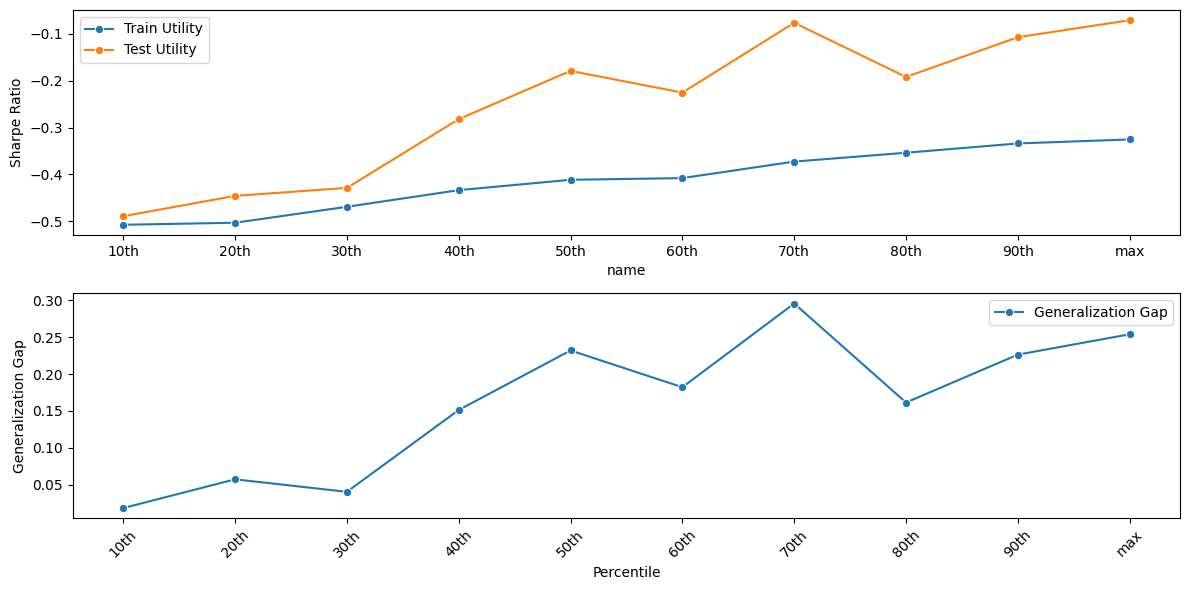

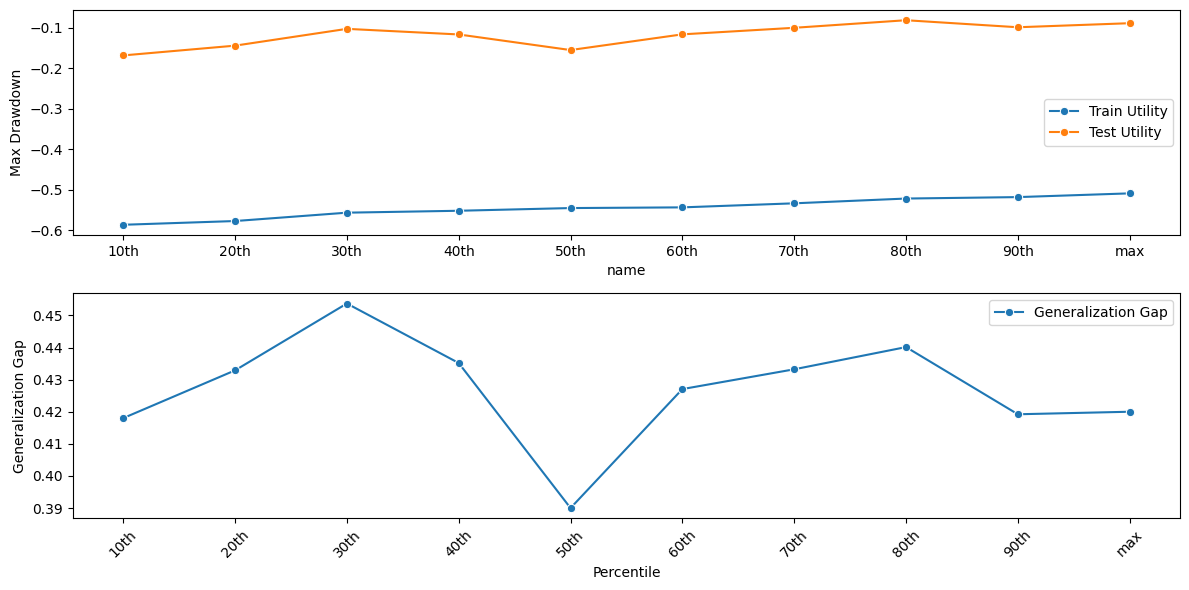

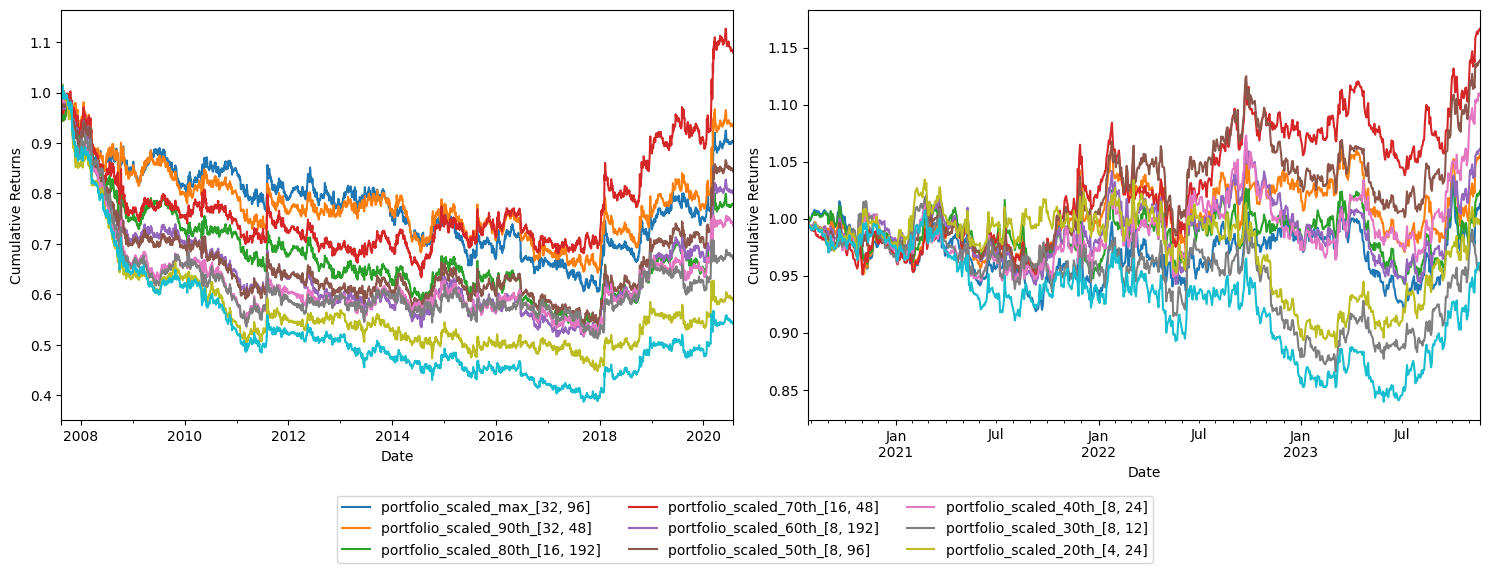

In [9]:
# metrics
test_maxdd_metrics_df = pd.DataFrame(test_maxdd_metrics)
test_maxdd_metrics_df['gap'] = test_maxdd_metrics_df['maxDD_test'] - test_maxdd_metrics_df['maxDD_train']

# portfolio returns
all_maxdd_portfolio_returns_df = pd.concat(all_maxdd_portfolio_returns, axis=1)

# portfolio returns
all_maxdd_portfolio_returns_df = pd.concat(all_maxdd_portfolio_returns, axis=1)


plot_df = test_sharpe_metrics_df.copy()
plot_df = plot_df.sort_values(by='name')

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

utility = 'Sharpe Ratio'

# Plot Train Utility
sns.lineplot(data=plot_df, x='name', y='sharpe_train', ax=ax[0], marker='o', label='Train Utility')
sns.lineplot(data=plot_df, x='name', y='sharpe_test', ax=ax[0], marker='o', label='Test Utility')
ax[0].set_ylabel(f'{utility}')
ax[0].legend()

# Plot Generalization Gap
sns.lineplot(data=plot_df, x='name', y='gap', ax=ax[1], marker='o', label='Generalization Gap')
ax[1].set_xlabel('Percentile')
ax[1].set_ylabel('Generalization Gap')
ax[1].legend()

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(os.path.join(outputs_path, 'results', f'{utility.lower()}-gap-utility-macd-mom.png'))

# plt.show()

plot_df = test_maxdd_metrics_df.copy()
plot_df = plot_df.sort_values(by='name')

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

utility = 'Max Drawdown'

# Plot Train Utility
sns.lineplot(data=plot_df, x='name', y='maxDD_train', ax=ax[0], marker='o', label='Train Utility')
sns.lineplot(data=plot_df, x='name', y='maxDD_test', ax=ax[0], marker='o', label='Test Utility')
ax[0].set_ylabel(f'{utility}')
ax[0].legend()

# Plot Generalization Gap
sns.lineplot(data=plot_df, x='name', y='gap', ax=ax[1], marker='o', label='Generalization Gap')
ax[1].set_xlabel('Percentile')
ax[1].set_ylabel('Generalization Gap')
ax[1].legend()

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(os.path.join(outputs_path, 'results', f'{utility.lower()}-gap-utility-macd-mom.png'))

# plt.show()

# Calculate cumulative returns for train period (beginning until test date)
test_start_date = test_returns.index[0]
train_period_returns = all_sharpe_portfolio_returns_df.loc[:test_start_date].dropna()
train_cumret_df = (1 + train_period_returns).cumprod()

# Calculate cumulative returns starting from 1 at test date
test_period_returns = all_sharpe_portfolio_returns_df.loc[test_start_date:].dropna()
test_cumret_df = (1 + test_period_returns).cumprod()

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot: Train period cumulative returns (beginning until test date)
train_cumret_df.plot(ax=ax1, legend=False)
# ax1.set_title('Train Period Cumulative Returns')
ax1.set_ylabel('Cumulative Returns')
ax1.set_xlabel('Date')
ax1.grid(False)

# Right subplot: Test period cumulative returns (starting from 1 at test date)
test_cumret_df.plot(ax=ax2, legend=False)
# ax2.set_title('Test Period Cumulative Returns')
ax2.set_ylabel('Cumulative Returns')
ax2.set_xlabel('Date')
ax2.grid(False)

# Create shared legend below the plots
handles1, labels1 = ax1.get_legend_handles_labels()
# Remove the 'Test Start Date' from labels for the shared legend
portfolio_handles = handles1[:-1]  # Exclude the vertical line
portfolio_labels = labels1[:-1]   # Exclude the vertical line

# Add legend below the subplots
fig.legend(portfolio_handles,
           portfolio_labels,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=3)
plt.tight_layout()

plt.savefig(os.path.join(outputs_path, 'results', f'{utility.lower()}-cumret-macd-mom.png'), bbox_inches='tight')

# plt.show()
